# _Combinatorial_ (or _collage_) Data Augmentation

In this project I develop and test a data augmentation approach to solve image classification problems, when the number of labelled images is very low (e.g., 10 from each class). I use the Fashion MNIST dataset, which has 10 classes of clothing.

#### Problem setup: 

A training set of labelled images $X_t$ with $k$ categories. There is also a validation dataset of labelled images $X_v$, and both $X_t$, $X_v$ are drawn or generated with the same distribution. These two datasets have a low number of images from each class. The goal is to use these two datasets to develop a neural network that generalizes well to a disjoint (and much larger) test dataset. 

We assume that a pre-trained network, such as a _resnet_, is available. In fact, the approach that we introduce relies on using a rather powerful pre-trained network. 

For the problem to be of interest, the categories to be learned are not categories for which the available pre-trained network has been trained.

#### Benchmark solution:

The benchmark performance is given by a neural network $N_b$, which is obtained by applying a transfer learning process $T_b$ on a given pre-trained neural network $N_0$, using $X_t$ to adjust the weights of $N_0$, and $X_v$ to select the best performing set of weights along the epochs. Here we are going to use resnet34 as $N_0$.

#### Improved solution:

The improved solution relies on _collages_, which are simply rectangular arrays of images from $X_t$.

(1) Create a dataset of $M>>m$ _collages_ from $X_t$, which is denoted $C=C(X_t)$, having to $k$ categories. Obtain a neural network $N_{alt}$ by applying a transfer learning process $T_{alt}$, on $N_0$, using the dataset $C$. 

(2) Obtain a neural network $N_{cda}$, by applying a transfer learning process $T_{cda}$, on the neural network $N_{alt}$, using the datasets $X_t,X_v$ (in the same way the benchmark is obtained).

The processes $T_b$ and $T_{cda}$ should be essentially the same, aside from the fact that they are applied to two different pre-trained neural networks, $N_0$ and $N_{alt}$, with the same architecture, but different initial weights. Both transfers are based on the same datasets $X_t,X_v$, use the same data augmentations on $X_t$, and tune the exact same layers of their corresponding starting networks, $N_0$ and $N_{alt}$. The only advantage given to the benchmark is to double the number of epochs, for reasons explained later.

We call this method _combinatorial (or collage) data augmentation_ (CDA).

More precisely:

- Input of the problem: $(N_0, X_t, X_v)$, where $X_t,X_v$ are labelled images in $k$ classes, and $N_0$ is a pre-trained network _not_ trained on those classes. 

- Goal: obtain a network that generalizes better than the benchmark in classifying the $k$ classes on a testing dataset, disjoint from $X_t$ and $X_v$ but with the same distribution.

- Benchmark: $N_b$, a network obtained via $T_b: (N_0,X_t,X_v) \mapsto N_b$, tuning only the last $l$ layers from $N_0$, during $n_{ep}$ epochs.

- CDA steps:
    - Obtain $C=C(X_t)$, with $M>>m$ images (collages).
    - Obtain $N_{alt}$ as a result of $T_{alt}:(N_0,C) \mapsto N_{alt}$, tuning at least the last $l+1$ layers of $N_0$. 
    - Obtain $N_{cda}$ as a result of $T_{cda}:(N_{alt},X_t,X_v) \mapsto N_{cda}$, tuning only the last $l$ layers of $N_0$, during $n_{ep}$ epochs.

#### Collages:
The set $C=C(X_t)$ of collages over $X_t$ is the result of a data augmentation process that goes from the original $m$ images up (at most) $m^{(q^2)}$ images, where the integer $q$ is a parameter of the method ($q>1$, since $q=1$ is just the usual transfer learning).

In the experiments shown here we use $q=3$. 

For simplicity we assume that the $m$ images in $X_t,X_v$ have all the same size.

Given $q$, a collage is simply an array of $q^2$ images from $X_t$, in a $q \times q$ shape. One could also use rectangular (non-square arrays, but it's the same idea).

##### Labels in $C$
Each collage needs a label. There could be different ways to do this. To build each collage we are going to use only images from 2 categories. The labelling is through the _majority_ vote: the label of a collage is $c_1$ iff at least $q^2/2$ of the $q^2$ images used to build the collage are in class $c_1$.


#### Generating $C$

To generate the set of collages $C$, we generate $N$ collages for each possible pair of classes $c_1, c_2$, resulting in $45N$ collages in total.

Fix $c_1, c_2$. Pick a random integer $n_{cl1}$ from 0 to $q^2$, which will be the number of images from class $c_1$ in the collage, while $n_{cl2}$ will be the number of images from class $c_2$ in the collage. Pick $n_{cl1}$ random images from class $c_1$ in 'TRAIN', and likewise with $n_{cl2}$. Put these images in a list and shuffle it, and build a collage with this list of images. When given a list of $q^2$ images, a collage is built by placing each of the images in a $q \times q$ array, iterating through columns, and within each column iterating through each row. The label of the collage is the $c_1$ if $n_{cl1}>q^2/2$ and $c_2$ otherwise.

# Dataset

The Fashion-MNIST dataset https://github.com/zalandoresearch/fashion-mnist contains images for 10 categories of clothing, with 6,000 training images and 1,000 testing images for each category, giving at total of 70,000 images.

The list of categories is: 

- tshirt (T-shirt/top)
- trouser 
- pullover
- dress
- coat
- sandal
- shirt
- sneaker
- bag
- boot (Ankle boot)

### Note: we switch the training and testing sets.

This is because for $X_t$ and $X_v$ combined, we are going to use at most $100$ images from each category, so the Fashion-MNIST set assigned for _testing_ would be enough. On the other hand, we want to have a reliable measure of performance, so we use the assigned set for _training_ for that purpose.

# Experiment

The purpose of this project is to compare throughout a numerical experiment the two techniques described: the benchmark classification, obtained on straightforward transfer learning, versus the CDA approach introduced here.

There are some parameters of the experiment that we are going to be varying, and the performance of the two methods is going to be measured over all the values considered for these parameters.

- The value $m=|X_t|$. For simplicity all classes will have the same number of images in $X_t$ and $X_v$, and moreover $|X_t|/(|X_t|+|X_v|) = 0.8$. We introduce a parameter $s$, integer, and make $X_t$ with $8s$ images in each of the $k$ classes, and $X_v$ with $2s$ images in each class. For example, when $s=2$, then $X_t$ will have $16k$ images and $X_v$ will have $4k$ images. 

- Number of epochs used to obtain benchmark and the CDA classifier. The CDA will be obtained using $n_{eps}=100$ epochs, while the benchmark will be given twice the number of epochs, just in case longer training could allow it to find a better solution. Our goal is to see if CDA is better, so giving it a disadvantage would make the results more reliable. The reason we do so many epochs is that for such low training set, the batch size equals the training set, so an epoch equals an update of the weights. 


### Steps of the experiment

1. Fix $s$.

2. Get all 60,000 training images in folder 'test' (case sensitive), inside their corresponding class folders. Likewise for the 10,000 testing images, but in the folder 'train' (see comment above about switching the datasets).

3. Prepare the images for the experiment.

    - Pick $2s$ images from each class in 'train', and move them into a new validation folder VALID (in their corresponding class folders).

    - Pick $8s$ images from each class in 'train', and copy them into a new folder TRAIN (in their corresponding class folders).

From this point, the experiment continues using only the images in folders TRAIN, VALID, and test.

4. Obtain the benchmark classifier, using $2n_{eps}$ epochs to tune the last $l$ layers based on $X_t$, and save best model learned with respect to error rate on $X_v$ as 'benchmark'. 

5. Obtain the CDA classifier, using $n_{eps}$ epochs in $T_2$, and save the learned model as 'cda'.

    - Obtain $C=C(X_t)$, with $M>>m$ images in classes $c_1', c_2'$, and save the collages in TRAIN_ALT, in their corresponding class folders.

    - Obtain $N_{alt}$ as a result of $T_{alt}:(N_0,C) \mapsto N_{alt}$, on at least the last $l+1$ layers of $N_0$.

    - Obtain $N_{cda}$ as a result of $T_{cda}:(N_{alt},X_t,X_v) \mapsto N_{cda}$, on the last $l$ layers of $N_0$, during $n_{ep}$ epochs. As for the benchmark: tune the last $l$ layers based on $X_t$, and save best model learned with respect to error rate on $X_v$.


6. Compare CDA vs benchmark, based on error rates on TEST 

    - The learning process that produces the benchmark and the CDA classifiers would have saved the best model with respect to the error rate (lowest) on the VALID set. Use these models to classify the test set and measure the error rates obtained by both classifiers, as well as computing the confusion matrices.

### Parameters considered

We use $s$ in $1,2,3,4,5,7,10,15,30,50,100$. For low values of $s$ we repeat the experiment more times because the performance has more variance due to the low number of images in $X_t$ and $X_v$. For example for $s=1$ we do the experiment 5 times.

## Conclusions

[REWRITE]

NOTE: one could argue that benchmark vs cda is not a fair comparison because none of them is properly tuned. All parameters are default. To see how good this default training, do the training with all 60,000 train set, get best model with respect to a 10% validation set, and then evaluate on the test set of 10,000 images. See what that gives, and compare with state of the art. If these two are close, then this is somehow evidence that these default trainings are not too bad.

This notebook presents a technique to deal with transfer-learning when the set of labelled images is too small to do an effective transfer learning using a pre-trained NN that has not originally being trained on the given labels.

The technique is tested on the Fashion-MNIST dataset, showing very promising results in terms of error rate reduction on a test set.

The reduction on error rate depends on the categories used (here only binary case is studied), as well as the subset of images randomly selected for each run of the experiment.

The experiments show that almost every time the CDA technique has a significantly better performance than the benchmark.

Despite the dramatic reduction in the error rate on test set, it must be acknowledged that behind CDA there is a significant amount of training. For example, with 50,000 collages to obtain $N_{alt}$ and bs=64, the 2 epochs training $N_{alt}$ equates to 2*50000/64=1562 weights updates. Meanwhile, for the benchmark, 1 epoch equates to 1 weight update because the batch size in this case equals $m$, the number of training images. So, while the benchmark has 200 updates behind it, CDA has 100 updates + 1562 updates. It could be argued that to make things even in terms of weights updates, the benchmark should run 1662 epochs instead of 200. First, it is not clear that more epochs would reduce the error as substantially as CDA does (since it seems that within the 200 epochs the error rate on validation is not monotonically decreasing). More importantly, doing that many epochs for the benchmark would be extremely inefficient, so at the very least CDA gives an efficient way to do the weight updates.


In [1]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import * 

import numpy as np
import pandas as pd
import os
import gzip
from PIL import Image, ImageDraw, ImageOps
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from os import listdir, walk
from os.path import isfile, join
%matplotlib inline

In [2]:
path = Path('/home/jupyter/.fastai/data/fashion-mnist')

In [3]:
''' DO ONLY ONCE

%%bash
cd /home/jupyter/.fastai/data/fashion-mnist

mkdir train
mkdir test
mkdir train/tshirt
mkdir test/tshirt
mkdir train/trouser
mkdir test/trouser
mkdir train/pullover
mkdir test/pullover
mkdir train/dress
mkdir test/dress
mkdir train/coat
mkdir test/coat
mkdir train/sandal
mkdir test/sandal
mkdir train/shirt
mkdir test/shirt
mkdir train/sneaker
mkdir test/sneaker
mkdir train/bag
mkdir test/bag
mkdir train/boot
mkdir test/boot
''' 
0


0

## 1. Hyper-parameters


In [4]:
# DICTIONARY OF LABELS
label_dict = {0:'tshirt', 1:'trouser', 2:'pullover', 3:'dress', 4:'coat', 5:'sandal', 6:'shirt', 7:'sneaker', 8:'bag', 9:'boot'}
categories = list(label_dict.values())
k = len(label_dict)

In [5]:
n_ep = 100
q = 3

In [6]:
'''
s = 100
m = 10*s*k
print('s:', s)
print('m:', m)
print('Size of X_t:', 8*s*k)
print('Size of X_v:', 2*s*k)
'''
#0

"\ns = 100\nm = 10*s*k\nprint('s:', s)\nprint('m:', m)\nprint('Size of X_t:', 8*s*k)\nprint('Size of X_v:', 2*s*k)\n"

#### All the cells below will give the execution for the run with the specified hyper-parameters

## 2. Save all images

In [7]:
def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

##### Remove all images at the beginning of the experiment

In [8]:
%%bash
cd /home/jupyter/.fastai/data/fashion-mnist

rm train/tshirt/*.jpg
rm test/tshirt/*.jpg
rm train/trouser/*.jpg
rm test/trouser/*.jpg
rm train/pullover/*.jpg
rm test/pullover/*.jpg
rm train/dress/*.jpg
rm test/dress/*.jpg
rm train/coat/*.jpg
rm test/coat/*.jpg
rm train/sandal/*.jpg
rm test/sandal/*.jpg
rm train/shirt/*.jpg
rm test/shirt/*.jpg
rm train/sneaker/*.jpg
rm test/sneaker/*.jpg
rm train/bag/*.jpg
rm test/bag/*.jpg
rm train/boot/*.jpg
rm test/boot/*.jpg

##### Create all images

In [9]:
X_test, y_test = load_mnist(path, kind='t10k')

for j,l in enumerate(y_test):
    img = Image.fromarray(np.array(np.reshape(X_test[j],(28,28))))
    file_nm = (5-len(str(j)))*'0'+str(j)+'.jpg'
    img.save(path/('test/'+label_dict[l]+'/'+file_nm))

In [10]:
X_train, y_train = load_mnist(path, kind='train')

for j,l in enumerate(y_train):
    img = Image.fromarray(np.array(np.reshape(X_train[j],(28,28))))
    file_nm = (5-len(str(j)))*'0'+str(j)+'.jpg'
    img.save(path/('train/'+label_dict[l]+'/'+file_nm))

## 3. Data

In [11]:
data = (ImageItemList.from_folder(path/'train')
        .random_split_by_pct(0.1)
        .label_from_folder()
        .transform(get_transforms(), size=28)
        .databunch(bs=64).normalize(imagenet_stats))

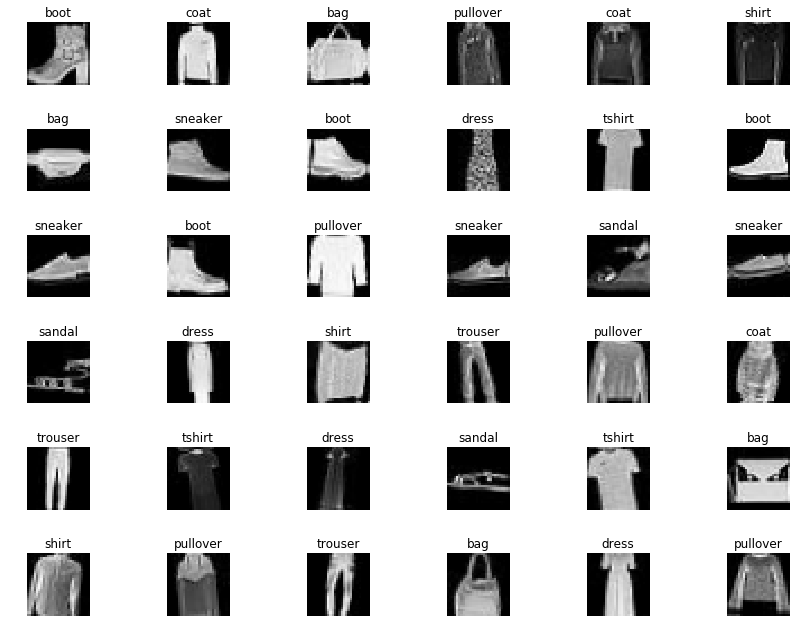

In [12]:
data.show_batch(rows=6, figsize=(12,9))

## 4. Benchmark

In [13]:
learn = create_cnn(data, models.resnet34, metrics=[error_rate])

In [14]:
learn.fit_one_cycle(2*n_ep,callbacks=[SaveModelCallback(learn,monitor='error_rate', mode='min')])

epoch,train_loss,valid_loss,error_rate
1,1.211436,1.012240,0.344000
2,1.068517,0.873602,0.303000
3,0.990681,0.814647,0.290333
4,0.948586,0.781478,0.280000
5,0.882900,0.730408,0.266667
6,0.837030,0.706539,0.255167
7,0.804762,0.682514,0.245167
8,0.772400,0.655053,0.242167
9,0.756153,0.632567,0.231333
10,0.711295,0.598794,0.220667


In [15]:
learn.save('project_4_benchmark')

## 5. Get CDA classifier

### 5.1 Obtain $C=C(X_t)$, with $M>>m$ images in classes.

Prepare folders to create $C$

In [16]:
%%bash

cd /home/jupyter/.fastai/data/fashion-mnist

rm -r TRAIN_ALT
mkdir TRAIN_ALT
cd TRAIN_ALT
mkdir tshirt
mkdir trouser
mkdir pullover
mkdir dress
mkdir coat
mkdir sandal
mkdir shirt
mkdir sneaker
mkdir bag
mkdir boot
cd ..

In [17]:
def collage_from_paths(subpaths, q, thumbnail_width=28, thumbnail_height=28):
    ''' Given a list of paths to q^2 images, this function returns a collage with the images'''
    size = thumbnail_width, thumbnail_height
    new_im = Image.new('RGB', (q*thumbnail_width, q*thumbnail_height))
    ims = []
    for subpath in subpaths:
        im = Image.open(path/subpath)
        im.thumbnail(size)
        ims.append(im)
    i = 0
    x = 0
    y = 0
    for cols in range(q):
        for row in range(q):
            new_im.paste(ims[i], (x, y))
            i += 1
            y += thumbnail_height
        x += thumbnail_width
        y = 0
    return new_im

In [18]:
N = 3000

In [19]:
pairs = list(itertools.combinations(categories, 2))
len(pairs)

45

In [20]:
def collage_from_classes(class1, class2, q):
    n_cl1 = np.random.choice(q*q+1)
    n_cl2 = q*q-n_cl1
    files_cl1 = np.random.choice([f for f in listdir(path/('TRAIN/'+class1)) if isfile(join(path/('TRAIN/'+class1), f))], n_cl1)
    paths_cl1 = ['TRAIN/'+class1+'/'+file_nm for file_nm in files_cl1]
    files_cl2 = np.random.choice([f for f in listdir(path/('TRAIN/'+class2)) if isfile(join(path/('TRAIN/'+class2), f))], n_cl2)
    paths_cl2 = ['TRAIN/'+class2+'/'+file_nm for file_nm in files_cl2]
    paths = paths_cl1+paths_cl2
    np.random.shuffle(paths)
    new_collage = collage_from_paths(paths, q)
    collage_nm = ''.join([path[-9:-4] for path in paths])+'.jpg'
    if n_cl1>(q*q/2):
        new_collage.save(path/('TRAIN_ALT/'+class1+'/'+collage_nm))
    else:
        new_collage.save(path/('TRAIN_ALT/'+class2+'/'+collage_nm))

In [21]:
for pair in pairs:
    for j in range(N):
        collage_from_classes(pair[0], pair[1], q)

In [22]:
n_collages = 0
for cat in categories:
    n_collages_cat = len([f for f in listdir(path/('TRAIN_ALT/'+cat)) if isfile(join(path/('TRAIN_ALT/'+cat), f))])
    n_collages = n_collages + n_collages_cat
    print('Number of collages with majority in', cat, n_collages_cat)

print('Number of collages',n_collages)

Number of collages with majority in tshirt 13422
Number of collages with majority in trouser 13572
Number of collages with majority in pullover 13420
Number of collages with majority in dress 13528
Number of collages with majority in coat 13422
Number of collages with majority in sandal 13580
Number of collages with majority in shirt 13553
Number of collages with majority in sneaker 13474
Number of collages with majority in bag 13448
Number of collages with majority in boot 13581
Number of collages 135000


In [23]:
data = (ImageItemList.from_folder(path/'TRAIN_ALT')
        .random_split_by_pct(0.2)
        .label_from_folder()
        .transform(get_transforms(), size=28*q)
        .databunch().normalize(imagenet_stats))

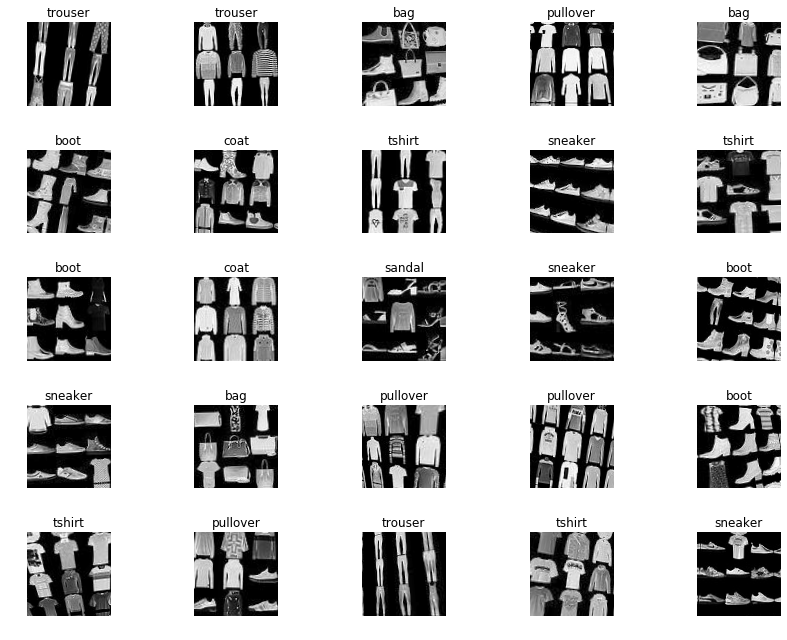

In [24]:
data.show_batch(rows=5, figsize=(12,9))

### 5.2 Obtain $N_{alt}$ as a result of $T_{alt}:(N_0,C) \mapsto N_{alt}$, on at least the last $l+1$ layers of $N_0$.

#### Depending on how many images are in TRAIN_ALT, this seems to determine the layers being calibrated, regardless of the freeze_to parameter (when the number of images is large. This becomes evident because even when one does freeze_to(-1), with a large amount of images, the error rate goes very low, which could not happen if the last layer is the only one being tuned.

In [25]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [26]:
learn.freeze_to(-10)
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate
1,0.305254,0.226101,0.083111
2,0.181163,0.121574,0.043889
3,0.137636,0.120409,0.044815
4,0.079881,0.052259,0.020556
5,0.063234,0.046851,0.017407


In [27]:
learn.save('project_4_alt')

### 5.3 Obtain $N_{cda}$ as a result of $T_{cda}:(N_{alt},X_t,X_v) \mapsto N_{cda}$, on the last $l$ layers of $N_0$, during $n_{ep}$ epochs.

In [28]:
data = (ImageItemList.from_folder(path/'train') 
        .random_split_by_pct(0.1)
        .label_from_folder()
        .transform(get_transforms(), size=28)
        .databunch(bs=64).normalize(imagenet_stats))

In [29]:
classes = data.classes

In [30]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [31]:
learn.load(path/'TRAIN_ALT/models/project_4_alt')

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (54000 items)
[Category pullover, Category pullover, Category pullover, Category pullover, Category pullover]...
Path: /home/jupyter/.fastai/data/fashion-mnist/train
x: ImageItemList (54000 items)
[Image (3, 28, 28), Image (3, 28, 28), Image (3, 28, 28), Image (3, 28, 28), Image (3, 28, 28)]...
Path: /home/jupyter/.fastai/data/fashion-mnist/train;

Valid: LabelList
y: CategoryList (6000 items)
[Category shirt, Category coat, Category dress, Category shirt, Category sneaker]...
Path: /home/jupyter/.fastai/data/fashion-mnist/train
x: ImageItemList (6000 items)
[Image (3, 28, 28), Image (3, 28, 28), Image (3, 28, 28), Image (3, 28, 28), Image (3, 28, 28)]...
Path: /home/jupyter/.fastai/data/fashion-mnist/train;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [32]:
#learn.fit_one_cycle(n_ep)
learn.fit_one_cycle(n_ep,callbacks=[SaveModelCallback(learn,monitor="error_rate",mode='min')])

epoch,train_loss,valid_loss,error_rate
1,0.552913,0.387931,0.119833
2,0.493976,0.338424,0.118333
3,0.455690,0.330021,0.119167
4,0.428145,0.324436,0.118833
5,0.440092,0.315583,0.115333
6,0.414914,0.312552,0.116500
7,0.397395,0.307566,0.114833
8,0.396815,0.308488,0.114333
9,0.372512,0.301750,0.112333
10,0.383129,0.299497,0.112000


In [33]:
learn.save('project_4_cda')

## 6. Compare CDA vs benchmark, based on error rates TEST 

In [34]:
def getClasses(predictions, actuals):
    '''Get the class names corresponding to the actuals, and predictions'''
    class_predictions = []
    class_actuals = []
    for k in range(len(actuals)):
        class_prediction = classes[np.argmax(predictions[k])]
        class_actual = classes[actuals[k]]
        class_predictions.extend([class_prediction])
        class_actuals.extend([class_actual])
    return [class_predictions, class_actuals]

In [37]:
def getTestPerformance(model_nm):
    data = (ImageItemList.from_folder(path)
            .split_by_folder(train='train', valid='test')
            .label_from_folder()
            .transform(get_transforms(), size=28)
            .databunch(bs=64).normalize(imagenet_stats))
    learn = create_cnn(data, models.resnet34, metrics=error_rate)
    learn.load(path/('models/'+model_nm))
    predictions, actuals = learn.get_preds(ds_type=DatasetType.Valid)
    [class_predictions, class_actuals] = getClasses(predictions, actuals)
    interp = ClassificationInterpretation.from_learner(learn)
    interp.plot_confusion_matrix(figsize=(8,8))
    return 1-accuracy_score(class_actuals, class_predictions)

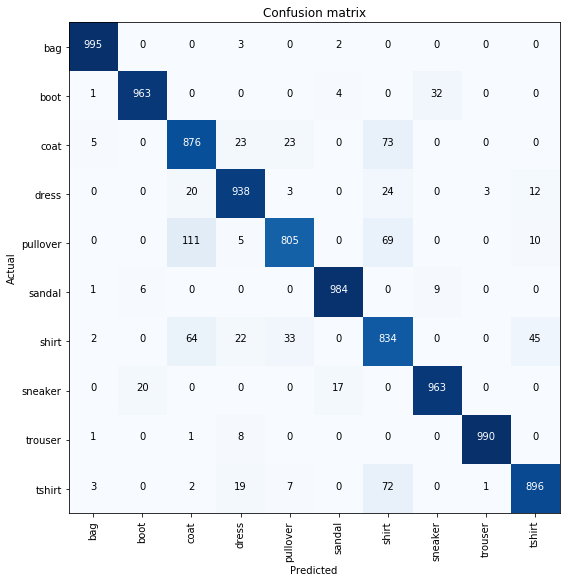

In [38]:
error_test_bench = getTestPerformance('project_4_benchmark')

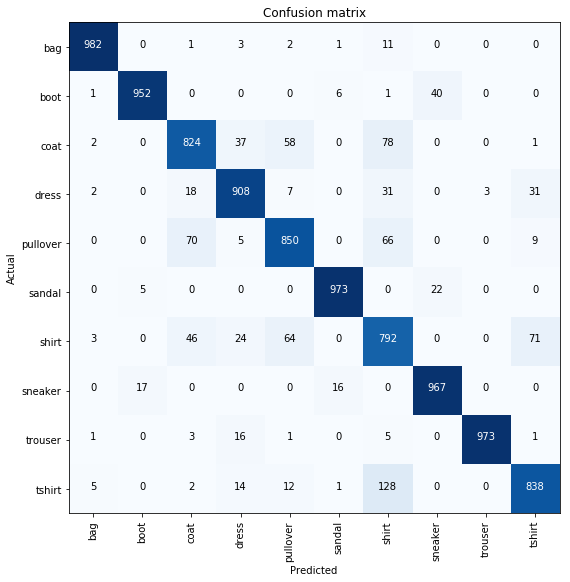

In [39]:
error_test_cda = getTestPerformance('project_4_cda')

In [40]:
print(error_test_bench, error_test_cda)

0.0756 0.09409999999999996
